In [2]:
import tclab
import numpy
import pandas

import tbcontrol
from tbcontrol import blocksim

import matplotlib.pyplot as plt
from latex_figure import plotfigure

import datetime

# Parameter Functions

In [3]:
def cohen_coon(controller_type, parameters):
    K, tau, theta =  parameters
    
    if controller_type == 'P':
        Kc = (1.03/K)*(tau/theta + 0.34)
        return Kc

#PI controller
    if controller_type == 'PI':
        Kc = (0.9/K)*(tau/theta + 0.092)
        tauI = (3.33*theta)*((tau + 0.092*theta)/(tau + 2.22*theta))
        return Kc, tauI


#PD controller
    if controller_type == 'PD':
        Kc = (1.24/K)*(tau/theta + 0.129)
        taud = 0.27*theta*((tau - 0.324*theta)/(tau + 0.129*theta))
        α = 2
        return Kc, taud, α

#PID controller
    if controller_type == 'PID':
        Kc = (1.35/K)*(tau/theta + 0.185)
        tauI = 2.5*theta*((tau + 0.185*theta)/(tau + 0.611*theta))
        taud = 0.37*theta*(tau/(tau + 0.185*theta))
        return Kc, tauI, taud

In [4]:
def IAE_setpoints(controller_type, parameters):
    K, tau, theta = parameters
#setpoints
    if controller_type == 'PI':   
        # PI
        Kc = (0.758/K)*(theta/tau)**-0.861
        tauI = tau/(1.02 - 0.323*(theta/tau))
        return Kc, tauI


    if controller_type == 'PID':
        # PID
        Kc = (1.086/K)*(theta/tau)**-0.869
        tauI = tau/(0.740 - 0.130*(theta/tau))
        taud = 0.348*tau*(theta/tau)**0.914
        return Kc, tauI, taud

In [5]:
def IAE_disturbances(controller_type, parameters):
    K, tau , theta = parameters
#disturbance
    if controller_type == 'P':
        # P
        Kc = (0.902/K)*(theta/tau)**-0.985
        return Kc
    
    if controller_type == 'PI':
        # PI
        Kc = (0.984/K)*(theta/tau)**-0.986
        tauI = (tau/0.608)*(theta/tau)**0.707
        return Kc, tauI

    if controller_type == 'PID':
        # PID
        Kc = (1.435/K)*(theta/tau)**-0.921
        tauI = (tau/0.878)*(theta/tau)**0.749
        taud = 0.482*tau*(theta/tau)**1.137
        return Kc, tauI, taud

# Block Sim Creation

In [6]:
def controller_block(controller_type, parameters):
    
    if controller_type == 'P':
        Kc_P = parameters
        Gc_P = blocksim.LTI('Gc_P', 'e', 'Q', Kc_P, 1)
        return Gc_P
    
    if controller_type == 'PI':
        Kc_PI, tauI_PI = parameters
        Gc_PI = blocksim.PI('Gc_PI','e','Q', Kc_PI, tauI_PI)
        return Gc_PI
    
    if controller_type == 'PD':
        Kc_PD, tauD_PD, α = parameters
        Gc_PD = blocksim.LTI('Gc_PD','e','Q', [Kc_PD * tauD_PD * (α + 1), Kc_PD], [tauD_PD * α, 1]) 
        # Used the α term for physical realizability - Textbook eq 7-12 pg 129
        return Gc_PD
    
    if controller_type == 'PID':
        Kc_PID, tauI_PID, tauD_PID = parameters
        Gc_PID = blocksim.PID('Gc_PID', 'e', 'Q', Kc_PID, tauI_PID, tauD_PID)
        return Gc_PID

In [7]:
def system_block(parameters):
    K, tau, theta = parameters
    Gp = blocksim.LTI('Gp', 'Q', 'Tp', K, [tau, 1], theta) # Block of the system FOPDT model
    return Gp

# Params

In [24]:
K_50 = 0.6423177737615754
tau_50 = 150.3121523254063
theta_50 = 17.396993066317368

In [25]:
params_50 = [K_50, tau_50, theta_50]

In [26]:
integral_steps = 10

In [213]:
run_length = 1500

# Runs

In [214]:
Gp = system_block(params_50)

In [215]:
all_controller_blocks# = [all_controller_blocks[0]]

[PI: e →[ Gc_PI ]→ Q, PI: e →[ Gc_PI ]→ Q, PI: e →[ Gc_PI ]→ Q]

In [241]:
noise = [0.01, 0.1, 0.1, 1]

In [242]:
sampling_rate = [1, 10, 25, 25]

In [243]:
total_time = run_length*len(noise)

In [244]:
all_controller_blocks = []
for i in noise:
    all_controller_blocks.append(controller_block('PI', IAE_setpoints('PI', params_50)))

In [245]:
str(datetime.timedelta(seconds=total_time)), total_time

('1:40:00', 6000)

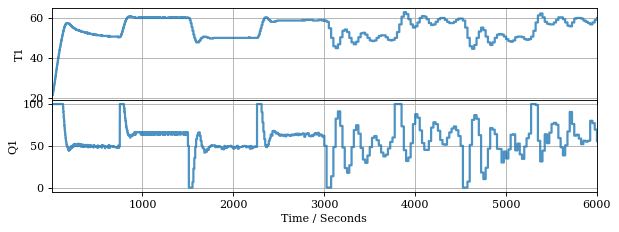

TCLab Model disconnected successfully.


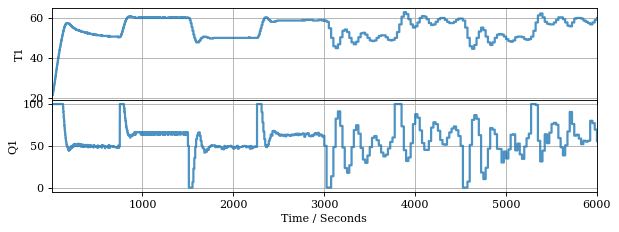

In [246]:
TCLab = tclab.setup(connected=False, speedup = 10)

with TCLab() as lab:
    sources = [('T1', lambda: lab.T1),
                ('Q1', lambda: lab.U1)]
    h = tclab.Historian(sources)
    p = tclab.Plotter(h, total_time)
    
    
    for index, Gc in enumerate(all_controller_blocks):
        n = noise[index]
        sample = sampling_rate[index]
        checker = 0
        for t in tclab.clock(run_length):         
            
            if t < run_length/2:
                T1sp = 50
            else:
                T1sp = 60
            
            if t/sample>=checker:
                Q1 = lab.Q1(float(Gc.output+50))
                T1 = lab.T1 + numpy.random.randn()*n
                e = T1sp-T1
                
                checker+=1
                print (T1, n, sample, t)

                for step in range(integral_steps):
                    Gc.change_input(t,e)
                    Gc.change_state(Gc.state+Gc.derivative(e)/integral_steps)

    #             h.update(t + index*run_length) 
                p.update(t + index*run_length)

In [247]:
h.get_sessions()

[(1, '2020-03-03 13:59:35', 1437)]

In [248]:
h.load_session(1)

In [249]:
data = {"Time" : h.t, "T1" : h.logdict['T1'], "Q1" : h.logdict['Q1']}

In [250]:
data_frame = pandas.DataFrame(data = data)
data_frame.to_csv("Combined Effects.csv")

data_frame.index = data_frame['Time']
data_frame = data_frame.drop(columns = 'Time')
data_frame

,T1,Q1
Time,,
0.00,20.9495,50.000000
3.00,20.9495,100.000000
4.00,20.9495,100.000000
6.00,21.2718,100.000000
7.00,21.2718,100.000000
...,...,...
5900.09,57.3694,56.091303
5925.09,56.7248,79.996860
5950.00,57.6917,77.130689


In [251]:
aspect_ratio = 4 / 5
FULLSIZE = 5, 5 * aspect_ratio
HALFSIZE = 3, 3 * aspect_ratio

In [252]:
y = []
x = []
for i in range(0,len(noise)):
    y_set = data_frame['T1'][1*i*run_length + run_length/2:1*i*run_length + run_length]
    
    y.append(y_set)
    
    x_set = (data_frame['T1'][1*i*run_length + run_length/2:1*i*run_length + run_length].index - 1*i*run_length)
    
    x.append(x_set)
    
#     print(x_set)
    print(y_set, '\n')

Time
750.01     50.2788
751.01     50.2788
753.00     50.2788
754.00     50.6011
756.00     50.6011
            ...   
1494.00    59.9478
1496.01    59.9478
1497.00    60.2701
1499.00    59.9478
1500.00    59.9478
Name: T1, Length: 579, dtype: float64 

Time
2250.02    49.9565
2260.02    49.9565
2270.01    50.6011
2280.01    51.5680
2290.04    53.1795
            ...   
2960.02    58.9809
2970.02    58.6586
2980.01    58.6586
2990.01    58.9809
3000.00    58.6586
Name: T1, Length: 76, dtype: float64 

Time
3750.07    48.9896
3775.02    49.9565
3800.02    52.8572
3825.08    56.7248
3850.09    60.5924
3875.07    62.8485
3900.05    61.8816
3925.08    59.3032
3950.07    56.7248
3975.04    55.1133
4000.07    55.7579
4025.02    57.6917
4050.01    59.9478
4075.06    60.9147
4100.02    60.5924
4125.02    59.3032
4150.08    57.3694
4175.07    56.4025
4200.02    56.7248
4225.06    58.0140
4250.05    59.3032
4275.05    59.9478
4300.09    59.9478
4325.06    58.9809
4350.05    58.0140
4375.04    57

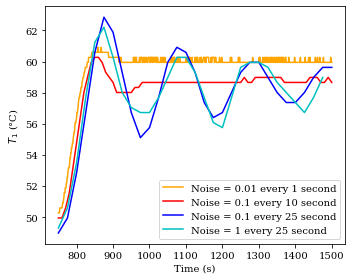

In [253]:
plotfigure(x, y, 
           ["Noise = {} every {} second".format(noise[i],sampling_rate[i]) for i in range(len(noise))], 
           ['orange', 'r','b', 'c'], 
           'Time (s)', '$T_1$ (\u00b0C)', 
           figsize = FULLSIZE, 
           filename = r'PDFS\\' + 'Sampling Rate and Noise.pdf',
            legend = True)
        